In [1]:
import sys
print("version:", sys.version)

version: 3.11.10 | packaged by Anaconda, Inc. | (main, Oct  3 2024, 07:22:26) [MSC v.1929 64 bit (AMD64)]


In [32]:
import torch
import torchvision
import functools
import pandas as pd
import seaborn
import brainscore_vision
from brainscore_vision import load_metric
from brainscore_vision.benchmark_helpers.neural_common import average_repetition
from brainscore_vision.model_helpers.activations.pytorch import PytorchWrapper
from brainscore_vision.model_helpers.activations.pytorch import load_preprocess_images
import warnings
warnings.filterwarnings("ignore")

In [7]:
neural_data = brainscore_vision.load_dataset("MajajHong2015.public")
neural_data = neural_data.transpose('presentation', 'neuroid', 'time_bin')

In [8]:
V4_data = neural_data.sel(region='V4')  
V4_data = average_repetition(V4_data)  
V4_data = V4_data.squeeze('time_bin')  
V4_data.shape

(3200, 88)

In [9]:
IT_data = neural_data.sel(region='IT')  # (1)
IT_data = average_repetition(IT_data)  # (2)
IT_data = IT_data.squeeze('time_bin')  # (3)
IT_data

<xarray.NeuronRecordingAssembly 'dicarlo.MajajHong2015.public' (
                                                                presentation: 3200,
                                                                neuroid: 168)>
dask.array<getitem, shape=(3200, 168), dtype=float32, chunksize=(1, 168), chunktype=numpy.ndarray>
Coordinates:
  * neuroid          (neuroid) MultiIndex
  - neuroid_id       (neuroid) object 'Chabo_L_M_5_9' ... 'Tito_L_M_8_0'
  - arr              (neuroid) object 'M' 'M' 'M' 'M' 'M' ... 'M' 'M' 'M' 'M'
  - col              (neuroid) int64 9 9 8 9 8 8 7 7 5 6 ... 1 0 1 0 1 0 0 1 1 0
  - hemisphere       (neuroid) object 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L'
  - subregion        (neuroid) object 'cIT' 'cIT' 'cIT' ... 'pIT' 'pIT' 'pIT'
  - animal           (neuroid) object 'Chabo' 'Chabo' 'Chabo' ... 'Tito' 'Tito'
  - y                (neuroid) float64 0.2 0.6 0.2 1.0 0.6 ... 1.0 1.0 1.8 1.4
  - x                (neuroid) float64 1.8 1.8 1.4 1.8 ... -1.8 -1.4 -1.4 -1.8
  - row              (neuroid) int64 5 6 5 7 6 7 9 7 9 8 ... 4 4 5 5 6 6 7 7 9 8
    time_bin         object (70, 170)
  * presentation     (presentation) MultiIndex
  - image_id         (presentation) object '0015b49a190e9bce70b108b28dc1a0674...
  - stimulus         (presentation) int32 212 161 1734 1634 ... 990 253 1818 323
  - stimulus_id      (presentation) object '0015b49a190e9bce70b108b28dc1a0674...
  - id               (presentation) int32 210 802 2367 2268 ... 894 2451 964
  - background_id    (presentation) object '561c84a23fcc11df50a1c441a23d19cb4...
  - s                (presentation) float64 1.0 1.133 0.9617 ... 0.916 0.7786
  - image_file_name  (presentation) object 'DTUG_L_rx+00.000_ry+00.000_rz+00....
  - filename         (presentation) object 'DTUG_L_rx+00.000_ry+00.000_rz+00....
  - rxy              (presentation) float64 -0.0 19.93 -41.9 ... 35.54 -34.78
  - tz               (presentation) float64 0.0 0.009 0.549 ... 0.297 0.485
  - category_name    (presentation) object 'Boats' 'Animals' ... 'Cars' 'Tables'
  - rxz_semantic     (presentation) float64 0.0 43.35 13.67 ... 36.42 -8.024
  - ty               (presentation) float64 0.0 0.068 -0.263 ... -0.12 0.173
  - ryz              (presentation) float64 -0.0 38.46 23.85 ... 6.701 -25.66
  - object_name      (presentation) object 'ship2' 'bear' ... 'table0'
  - variation        (presentation) int32 0 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3
  - size             (presentation) float64 256.0 256.0 256.0 ... 256.0 256.0
  - rxy_semantic     (presentation) float64 90.0 109.9 -131.9 ... 125.5 -34.78
  - ryz_semantic     (presentation) float64 -0.0 38.46 23.85 ... 6.701 -25.66
  - rxz              (presentation) float64 0.0 43.35 13.67 ... 36.42 -8.024
Attributes:
    stimulus_set_identifier:  hvm-public
    stimulus_set:                     id                             backgrou...
    identifier:               dicarlo.MajajHong2015.public

In [10]:
def preprocess_FreemanZiemba2013(assembly, region):
    assembly = assembly.sel(region=region)
    assembly = assembly.stack(neuroid=['neuroid_id'])  # work around xarray multiindex issues
    assembly['region'] = 'neuroid', [region] * len(assembly['neuroid'])
    assembly.load()
    time_window = (50, 200)
    assembly = assembly.sel(time_bin=[(t, t + 1) for t in range(*time_window)])
    assembly = assembly.mean(dim='time_bin', keep_attrs=True)
    assembly = assembly.expand_dims('time_bin_start').expand_dims('time_bin_end')
    assembly['time_bin_start'], assembly['time_bin_end'] = [time_window[0]], [time_window[1]]
    assembly = assembly.stack(time_bin=['time_bin_start', 'time_bin_end'])
    assembly = assembly.squeeze('time_bin')
    assembly = assembly.transpose('presentation', 'neuroid')
    assembly = average_repetition(assembly)
    return assembly



neural_data = brainscore_vision.load_dataset("FreemanZiemba2013.public")
V1_data = preprocess_FreemanZiemba2013(neural_data, 'V1')
V2_data = preprocess_FreemanZiemba2013(neural_data, 'V2')

In [11]:
alexnet = torchvision.models.alexnet(weights='IMAGENET1K_V1')
preprocessing = functools.partial(load_preprocess_images, image_size=224)
alexnet = PytorchWrapper(identifier='alexnet', model=alexnet, preprocessing=preprocessing)
alexnet.image_size = 224
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [22]:
import shutil
import os

cache_dir = "C:\\Users\\thorr\\.result_caching"


In [23]:


rdm_metric = load_metric('rdm')
scores = {'model': [], 'layer': [], 'region': [], 'score': []}
alexnet_layers = ['features.2', 'features.7', 'features.12']

stimulus_set_IT_V4 = IT_data.stimulus_set

for model, model_id in [(alexnet, 'alexnet')]:
  print(model_id)
  for layer in alexnet_layers:
    if os.path.exists(cache_dir):
        shutil.rmtree(cache_dir)
    print(layer)
    alexnet_activations = model(stimulus_set_IT_V4, layers=[layer])
    print(f'computing representational similarity between IT activations and layer {layer} activations')
    score = rdm_metric(assembly1=IT_data, assembly2=alexnet_activations)
    scores['model'].append(model_id)
    scores['layer'].append(layer)
    scores['region'].append('IT')
    scores['score'].append(score)
    print(f'computing representational similarity between V4 activations and layer {layer} activations')
    score = rdm_metric(assembly1=V4_data, assembly2=alexnet_activations)
    scores['model'].append(model_id)
    scores['layer'].append(layer)
    scores['region'].append('V4')
    scores['score'].append(score)

stimulus_set_V1_V2 = V1_data.stimulus_set

alexnet
features.2


activations:   0%|          | 0/3200 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

computing representational similarity between IT activations and layer features.2 activations
computing representational similarity between V4 activations and layer features.2 activations
features.7


activations:   0%|          | 0/3200 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

computing representational similarity between IT activations and layer features.7 activations
computing representational similarity between V4 activations and layer features.7 activations
features.12


activations:   0%|          | 0/3200 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

computing representational similarity between IT activations and layer features.12 activations
computing representational similarity between V4 activations and layer features.12 activations


In [27]:
res_df = pd.DataFrame(scores)
res_df['score'] = [e.values for e in res_df['score']]
res_df

,model,layer,region,score
0,alexnet,features.2,IT,0.12068756740806387
1,alexnet,features.2,V4,0.09188487649076102
2,alexnet,features.7,IT,0.14552759503130697
3,alexnet,features.7,V4,0.08810310910203399
4,alexnet,features.12,IT,0.2936438135575295
5,alexnet,features.12,V4,0.1333696382356754


In [28]:
PATH = 'alexnetVSventralstream.txt'
res_df.to_csv(PATH)

In [30]:
res_df = pd.read_csv(PATH)

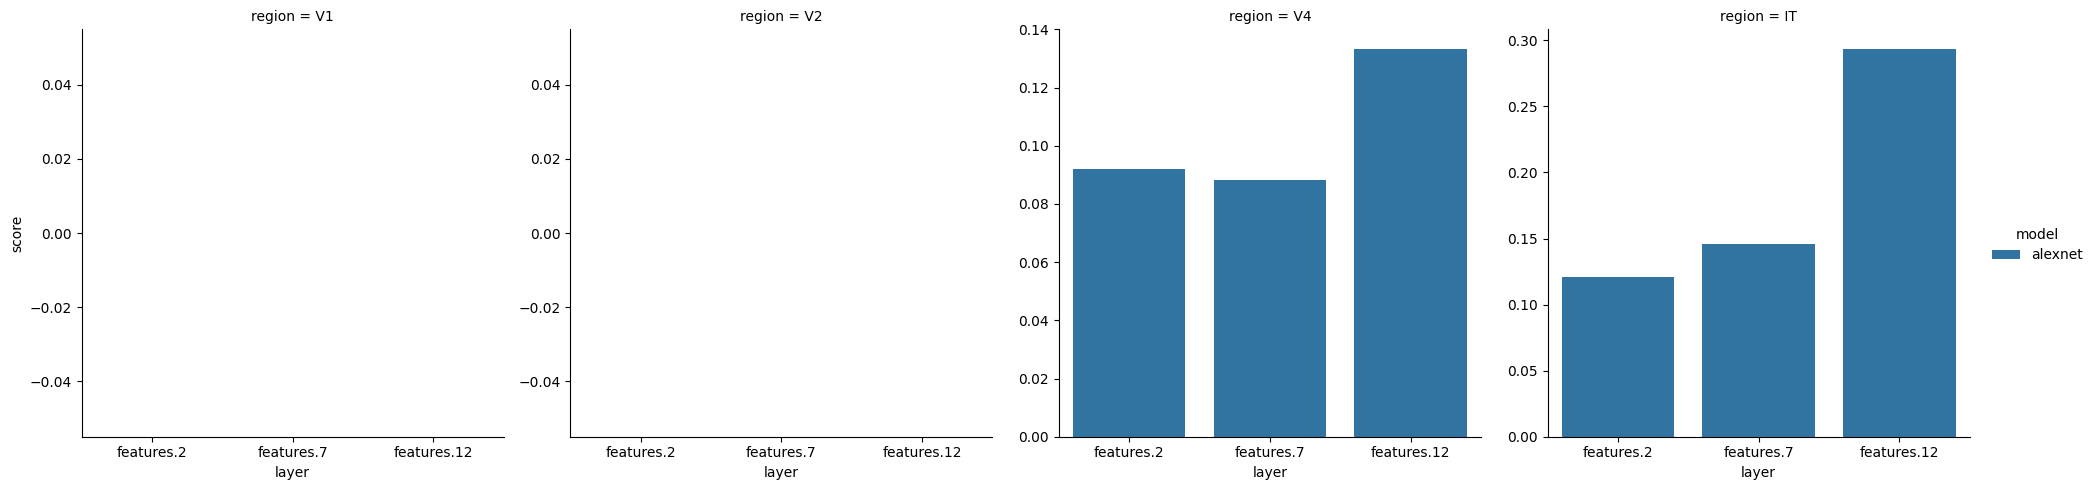

In [33]:

seaborn.catplot(data=res_df, y='score', x='layer', hue='model', col='region', kind='bar',
                col_order=['V1', 'V2', 'V4', 'IT'], sharey=False)